In [31]:
import pyspark
import pandas as pd

In [2]:
sc = pyspark.SparkContext(appName="teste")

In [3]:
sc

<SparkContext master=local[*] appName=teste>

In [4]:
sc.parallelize(range(1000)).count()

1000

In [5]:
rdd = sc.sequenceFile("web_brasil_small/part-00000") #rdd = sc.textFile("web_brasil_small/part-00000")

In [6]:
rdd.count()

36133

In [7]:
rdd.filter(lambda x: "fiscal" in x[1]).count()

1162

In [8]:
rdd.take(1)

[('https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136',
  'Sebo do Messias - Suas Compras\nLivroDVDCDLPGibiRevista\n|\nBusca avancada\nBem-vindo ao\nSebo do Messias.\nFaça o seu LOGIN\nMinha conta\nAlterar senha\nAlterar Email\nMeu Carrinho\nHistórico de Pedidos\nMeus Interesses\nSair\n1\nNão possui conta?\nCadastre-se\nOlá, seja bem-vindo!\n×\nPara prosseguir, por favor identifique-se utilizando os campos abaixo e depois clique no botão “ENTRAR”.\nE-mail\nSenha\nEsqueci minha senha\nEsqueceu sua senha?\n×\nPreencha o seu email no campo abaixo e clique no botão "ENVIAR".\nE-mail\nFaça seu login\nConfirmado!\n×\nEnviamos uma mensagem em seu e-mail para alteração de senha.\n(se não encontra-lo, verifique sua caixa de spam).\nFaça seu login\nNão possui conta?\nCadastre-se\nBusca Avançada\n×\nIndique as opções relevantes a sua busca.\nBusca por: LivroDVDCDLPGibiRevista\nÁlbum:\nArtista / Banda:\nAno:\nGravadora: Selecione uma Gravadora32 Blues4adABKCOABRIL MUS

In [9]:
import math


def conta_palavras_em_doc(item):
    url, text = item
    words = text.strip().split()
    return [(word.lower(), 1) for word in set(words)] # set() -> contagem de documentos que a palavra aparece

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

def computa_relevancia(item):
    palavra, valor = item
    freq, idf = valor
    relevancia = freq*idf
    return (palavra, relevancia)
    
def conta_palavras_total(item):
    url, text = item
    words = text.strip().split()
    return [(word.lower(), 1) for word in words]

def filtra_doc_freq(item):
    palavra, contagem = item
    return (contagem < DOC_COUNT_MAX) and (contagem >= DOC_COUNT_MIN)

def sort_100(item):
    palavra, relevancia = item
    return 

def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(N / contagem)
    return(palavra, idf)

def computa_freq(item):
    palavra, contagem = item
    freq = math.log10(1+contagem)
    return(palavra, freq)

def encontra_palavra(item, palavra):
    url, text = item
    words = text.strip().split()
    words_list = [word.lower() for word in words]
    if palavra in words_list:
        return [item]
    return []

def encontra_palavra1(item):
    return encontra_palavra(item, palavra1)

def encontra_palavra2(item):
    return encontra_palavra(item, palavra2)

In [10]:
url, text = rdd.take(1)[0]
url

'https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136'

In [11]:
rdd_word_freq = rdd.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

In [12]:
rdd_word_freq.take(10)

[('login', 11306),
 ('senha', 8876),
 ('no', 208400),
 ('e-mail', 24013),
 ('esqueci', 1585),
 ('"enviar".', 5),
 ('confirmado!', 12),
 ('spam).', 8),
 ('musicatração', 4),
 ('musicb-uniquebama', 4)]

# Início do estudo

In [13]:
N = rdd.count()

DOC_COUNT_MIN = 10
DOC_COUNT_MAX = N * 0.7

palavra1 = 'boulos'
palavra2 = 'covas'

In [14]:
rdd_palavra1 = rdd.flatMap(encontra_palavra1)
rdd_palavra2 = rdd.flatMap(encontra_palavra2)

In [15]:
rdd_palavra1.count()

79

In [16]:
rdd_palavra2.count()

125

In [17]:
rdd_palavra_intersection = rdd_palavra1.intersection(rdd_palavra2)
rdd_palavra_intersection.count()

15

# IDF

In [66]:
rdd_doc_count_intersection = rdd.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)

rdd_idf = rdd_doc_count_intersection.map(computa_idf)

In [67]:
rdd_idf.take(10)

[('pons', 3.4117759853793284),
 ('r$', 0.5932673172690647),
 ('//}', 3.3274550996792924),
 ('à', 0.32189609502544525),
 ('e-mail', 0.43047524320596725),
 ('bom', 0.8289013117853762),
 ('joaquim', 1.6987657237630354),
 ('cantores', 2.5086859983873846),
 ('região', 0.881576287176246),
 ('*', 0.864528870032381)]

# COMPUTA FREQ

In [68]:
rdd_words_count = rdd_palavra_intersection.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

rdd_words_freq = rdd_words_count.map(computa_freq)

In [69]:
rdd_words_freq.take(10)

[('pra', 0.8450980400142568),
 ('culturais', 0.47712125471966244),
 ('eleições', 1.6532125137753437),
 ('r$', 1.6232492903979006),
 ('cargos', 0.6020599913279624),
 ('celso', 1.1139433523068367),
 ('tatto-pt,', 0.3010299956639812),
 ('helou', 0.3010299956639812),
 ('vereadores', 0.6020599913279624),
 ('mesmo', 1.3222192947339193)]

# TABELA 1

In [70]:
rdd_join = rdd_words_freq.join(rdd_idf)
rdd_relevancia = rdd_join.map(computa_relevancia)

list_relevance = rdd_relevancia.takeOrdered(100, key=lambda x: -x[1])
#list_relevance = sorted(list_relevance, key=lambda x: -x[1])[:100]
list_relevance

# TABELA 2a

In [82]:
#rdd_doc_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
#rdd_idf_palavra1 = rdd_doc_count_palavra1.map(computa_idf)

rdd_words_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra1 = rdd_words_count_palavra1.map(computa_freq)

rdd_join_palavra1 = rdd_words_freq_palavra1.join(rdd_idf)
rdd_relevancia_palavra1 = rdd_join_palavra1.map(computa_relevancia)

list_relevance_palavra1 = rdd_relevancia_palavra1.takeOrdered(100, key=lambda x: -x[1])
#list_relevance_palavra1 = sorted(list_relevance_palavra1, key=lambda x: -x[1])[:100]
list_relevance_palavra1

[('curtircurtir', 6.747774501935724),
 ('libertários', 6.477448037066816),
 ('hoppe', 6.295061183591109),
 ('boitempo', 6.186805438458406),
 ('poder360', 6.10820185049519),
 ('slavoj', 6.009742390407225),
 ('ubes', 5.885580753843558),
 ('grabois', 5.816764900446318),
 ('libertário', 5.682383918685022),
 ('žižek', 5.6818630905173455),
 ('►', 5.572573851405013),
 ('conservadores', 5.564899699782798),
 ('belluzzo', 5.52232308337811),
 ('boulos', 5.225956157639864),
 ('gramacho', 5.087277221420039),
 ('occupy', 5.057910537443251),
 ('conservador', 4.982919500728973),
 ('pcdob', 4.9712411387046505),
 ('capitalismo', 4.957445550019883),
 ('ñ', 4.877216207686431),
 ('quartim', 4.8437027829596175),
 ('conservadorismo', 4.78823048672405),
 ('marx', 4.7829264308553405),
 ('invasor', 4.762798656546971),
 ('(pt)', 4.7340128061400675),
 ('goldman', 4.730582034457487),
 ('fonteles', 4.727267078306393),
 ('capitalista', 4.702938819593356),
 ('sorrentino', 4.673135573243737),
 ('socialismo', 4.6106992

# TABELA 2b

In [83]:
#rdd_doc_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
#rdd_idf_palavra2 = rdd_doc_count_palavra2.map(computa_idf)


rdd_words_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra2 = rdd_words_count_palavra2.map(computa_freq)

rdd_join_palavra2 = rdd_words_freq_palavra2.join(rdd_idf)
rdd_relevancia_palavra2 = rdd_join_palavra2.map(computa_relevancia)

list_relevance_palavra2 = rdd_relevancia_palavra2.takeOrdered(100, key=lambda x: -x[1])
#list_relevance_palavra2 = sorted(list_relevance_palavra2, key=lambda x: -x[1])[:100]
list_relevance_palavra2

[('circunscrição', 7.650524472872536),
 ('pró-memória', 5.776764478594256),
 ('relacionadas:', 5.753616839199643),
 ('judiciária', 5.73914307155359),
 ('geográfico', 5.621576821350564),
 ('viomundo', 5.571069842337211),
 ('covas', 5.4876626929325365),
 ('forth', 5.349274480190002),
 ('dibrarq', 5.252633851524595),
 ('pretoria', 5.194313636719551),
 ('\\n', 5.137122323535196),
 ('janeiro),', 5.08819201253841),
 ('estadão', 5.083388599350974),
 ('moços', 5.042433653710402),
 ('sepultado', 5.028835107084682),
 ('internado', 4.982312061783804),
 ('fundo/coleção', 4.9428208649312335),
 ('mayara', 4.927901315187599),
 ('[encolher]', 4.915054651861616),
 ('memorial', 4.912111648196622),
 ('mensalão', 4.905940331925442),
 ('[ler', 4.8783872087230575),
 ('nordestinos', 4.848514575893497),
 ('fertilizante', 4.8409677416663515),
 ('pesar', 4.830918873089393),
 ('auditoria', 4.802130416134453),
 ('documentação', 4.774784035301358),
 ('goldman', 4.77258403915202),
 ('comentado', 4.77108752885312),


In [85]:
df_palavra1 = pd.DataFrame(list_relevance_palavra1, columns =['Palavra', 'Relevância']) 
df_palavra2 = pd.DataFrame(list_relevance_palavra2, columns =['Palavra', 'Relevância']) 
df_palavra_intersect = pd.DataFrame(list_relevance, columns =['Palavra', 'Relevância']) 

In [86]:
#df_palavra1.to_csv("ResultadoPalavra1.csv")
#df_palavra2.to_csv("ResultadoPalavra2.csv")
#df_palavra_intersect.to_csv("ResultadoIntersect.csv")

In [87]:
def Convert(tup):
    di = {}
    for a, b in tup: 
        di[a] = b 
    return di 

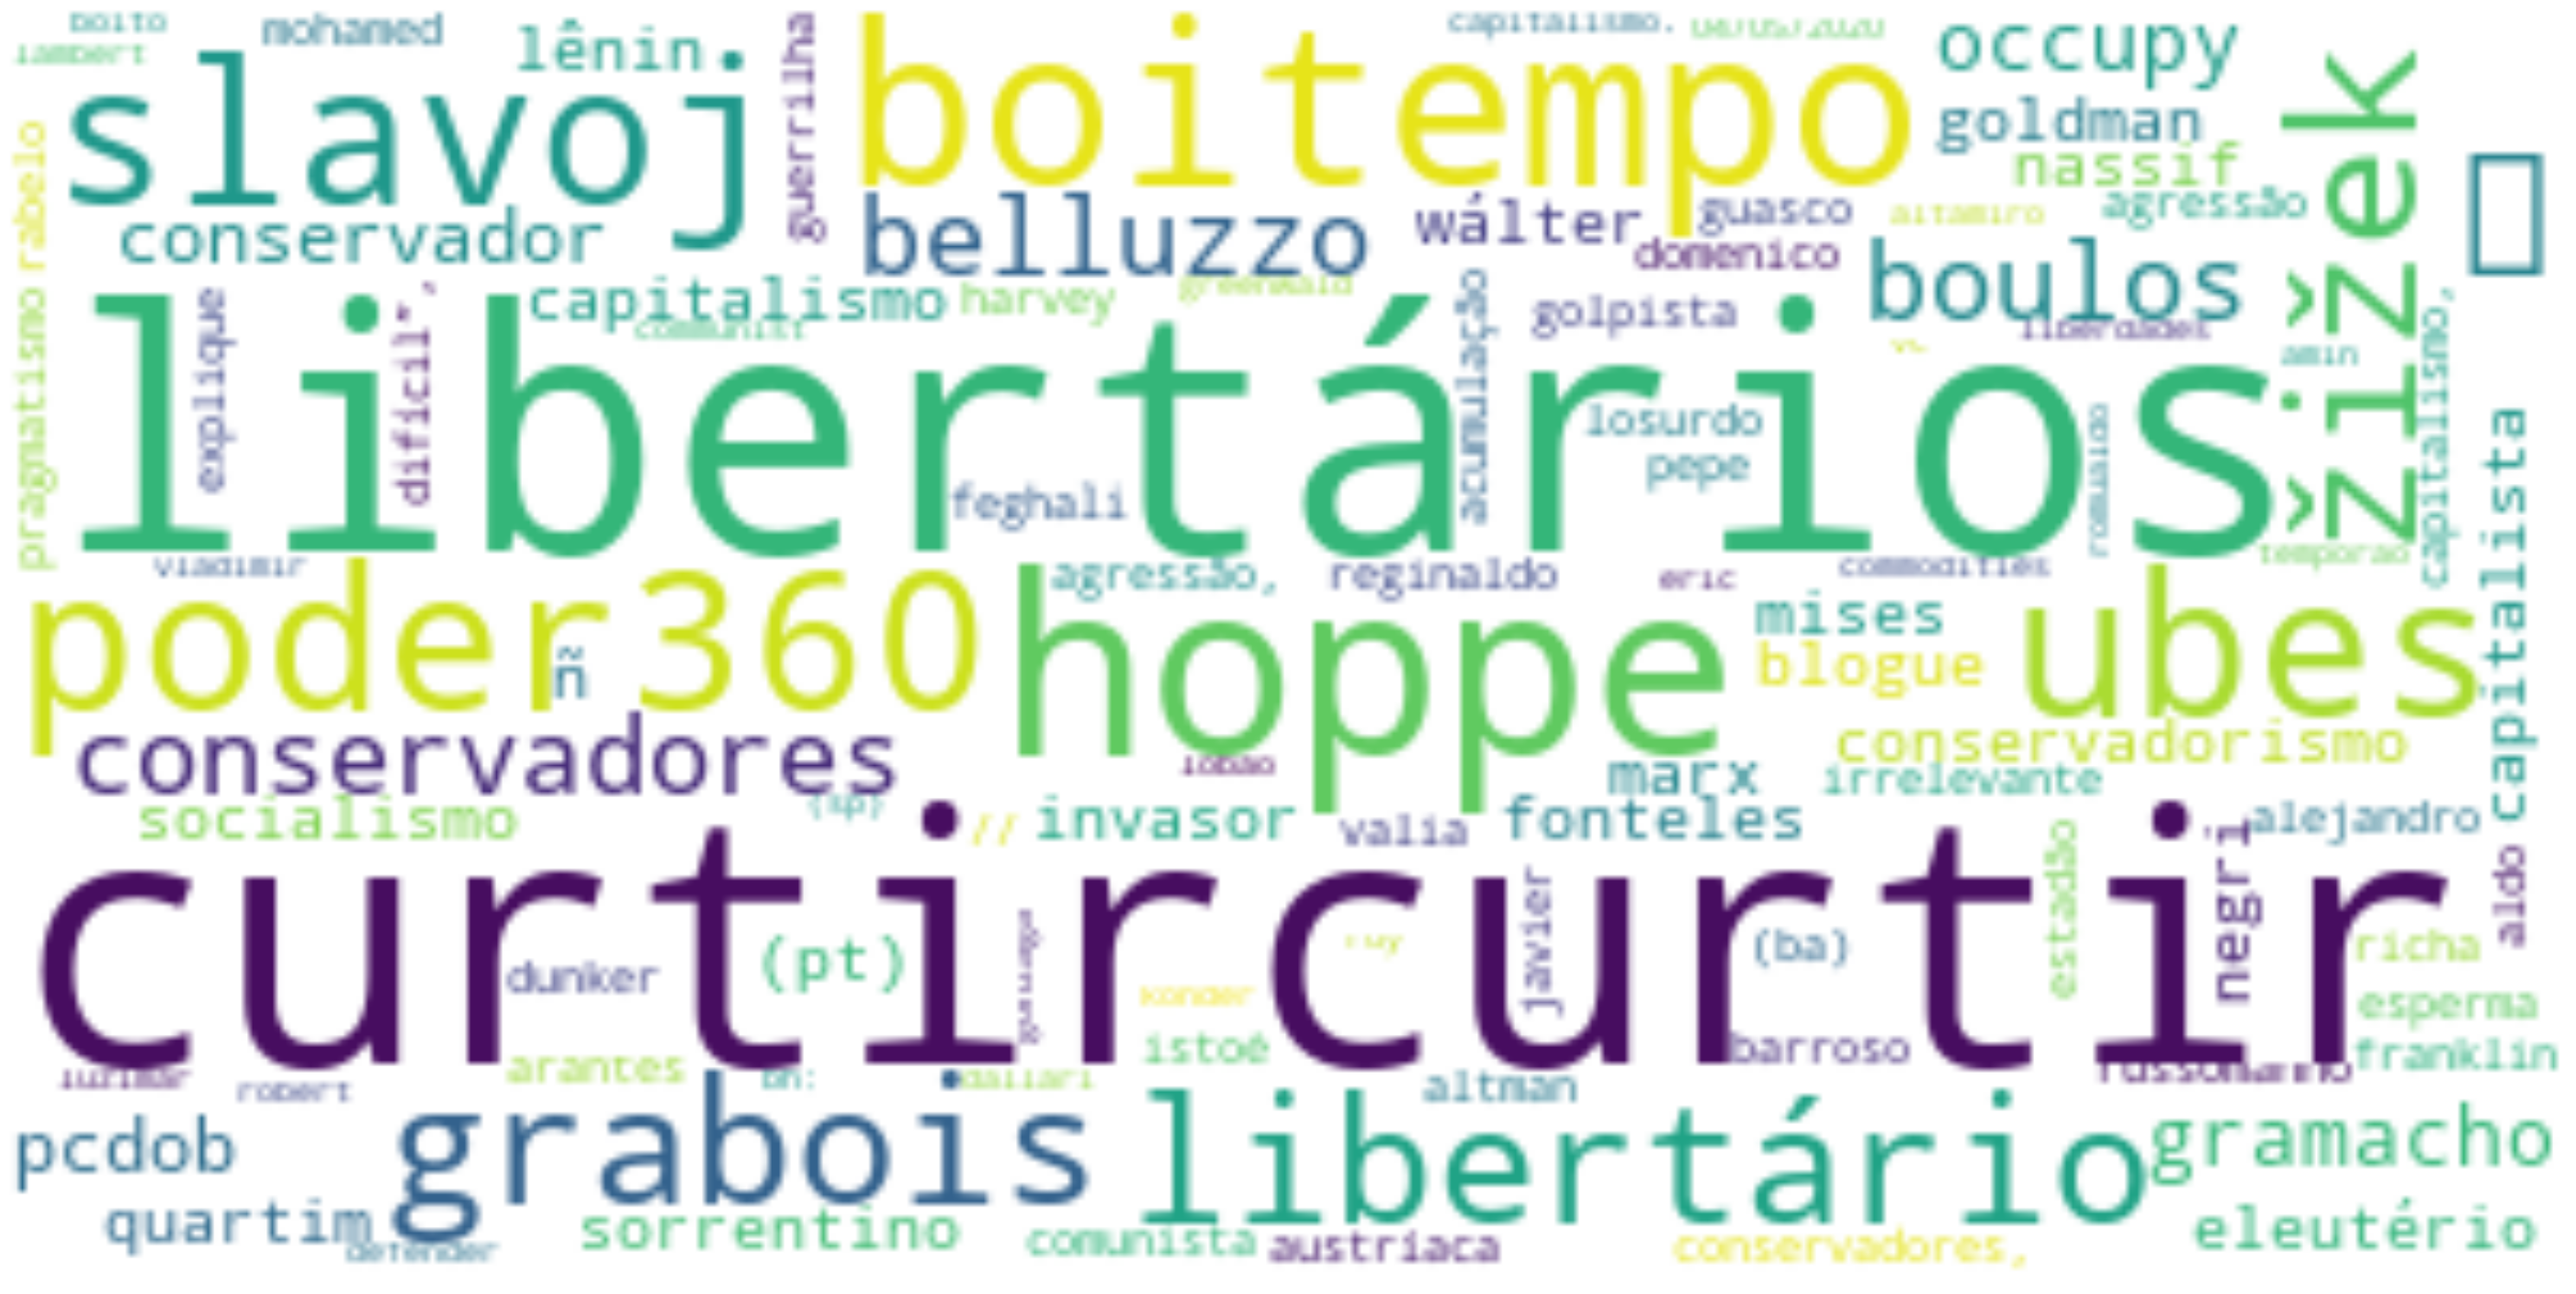

Boulos


In [88]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra1))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Boulos")

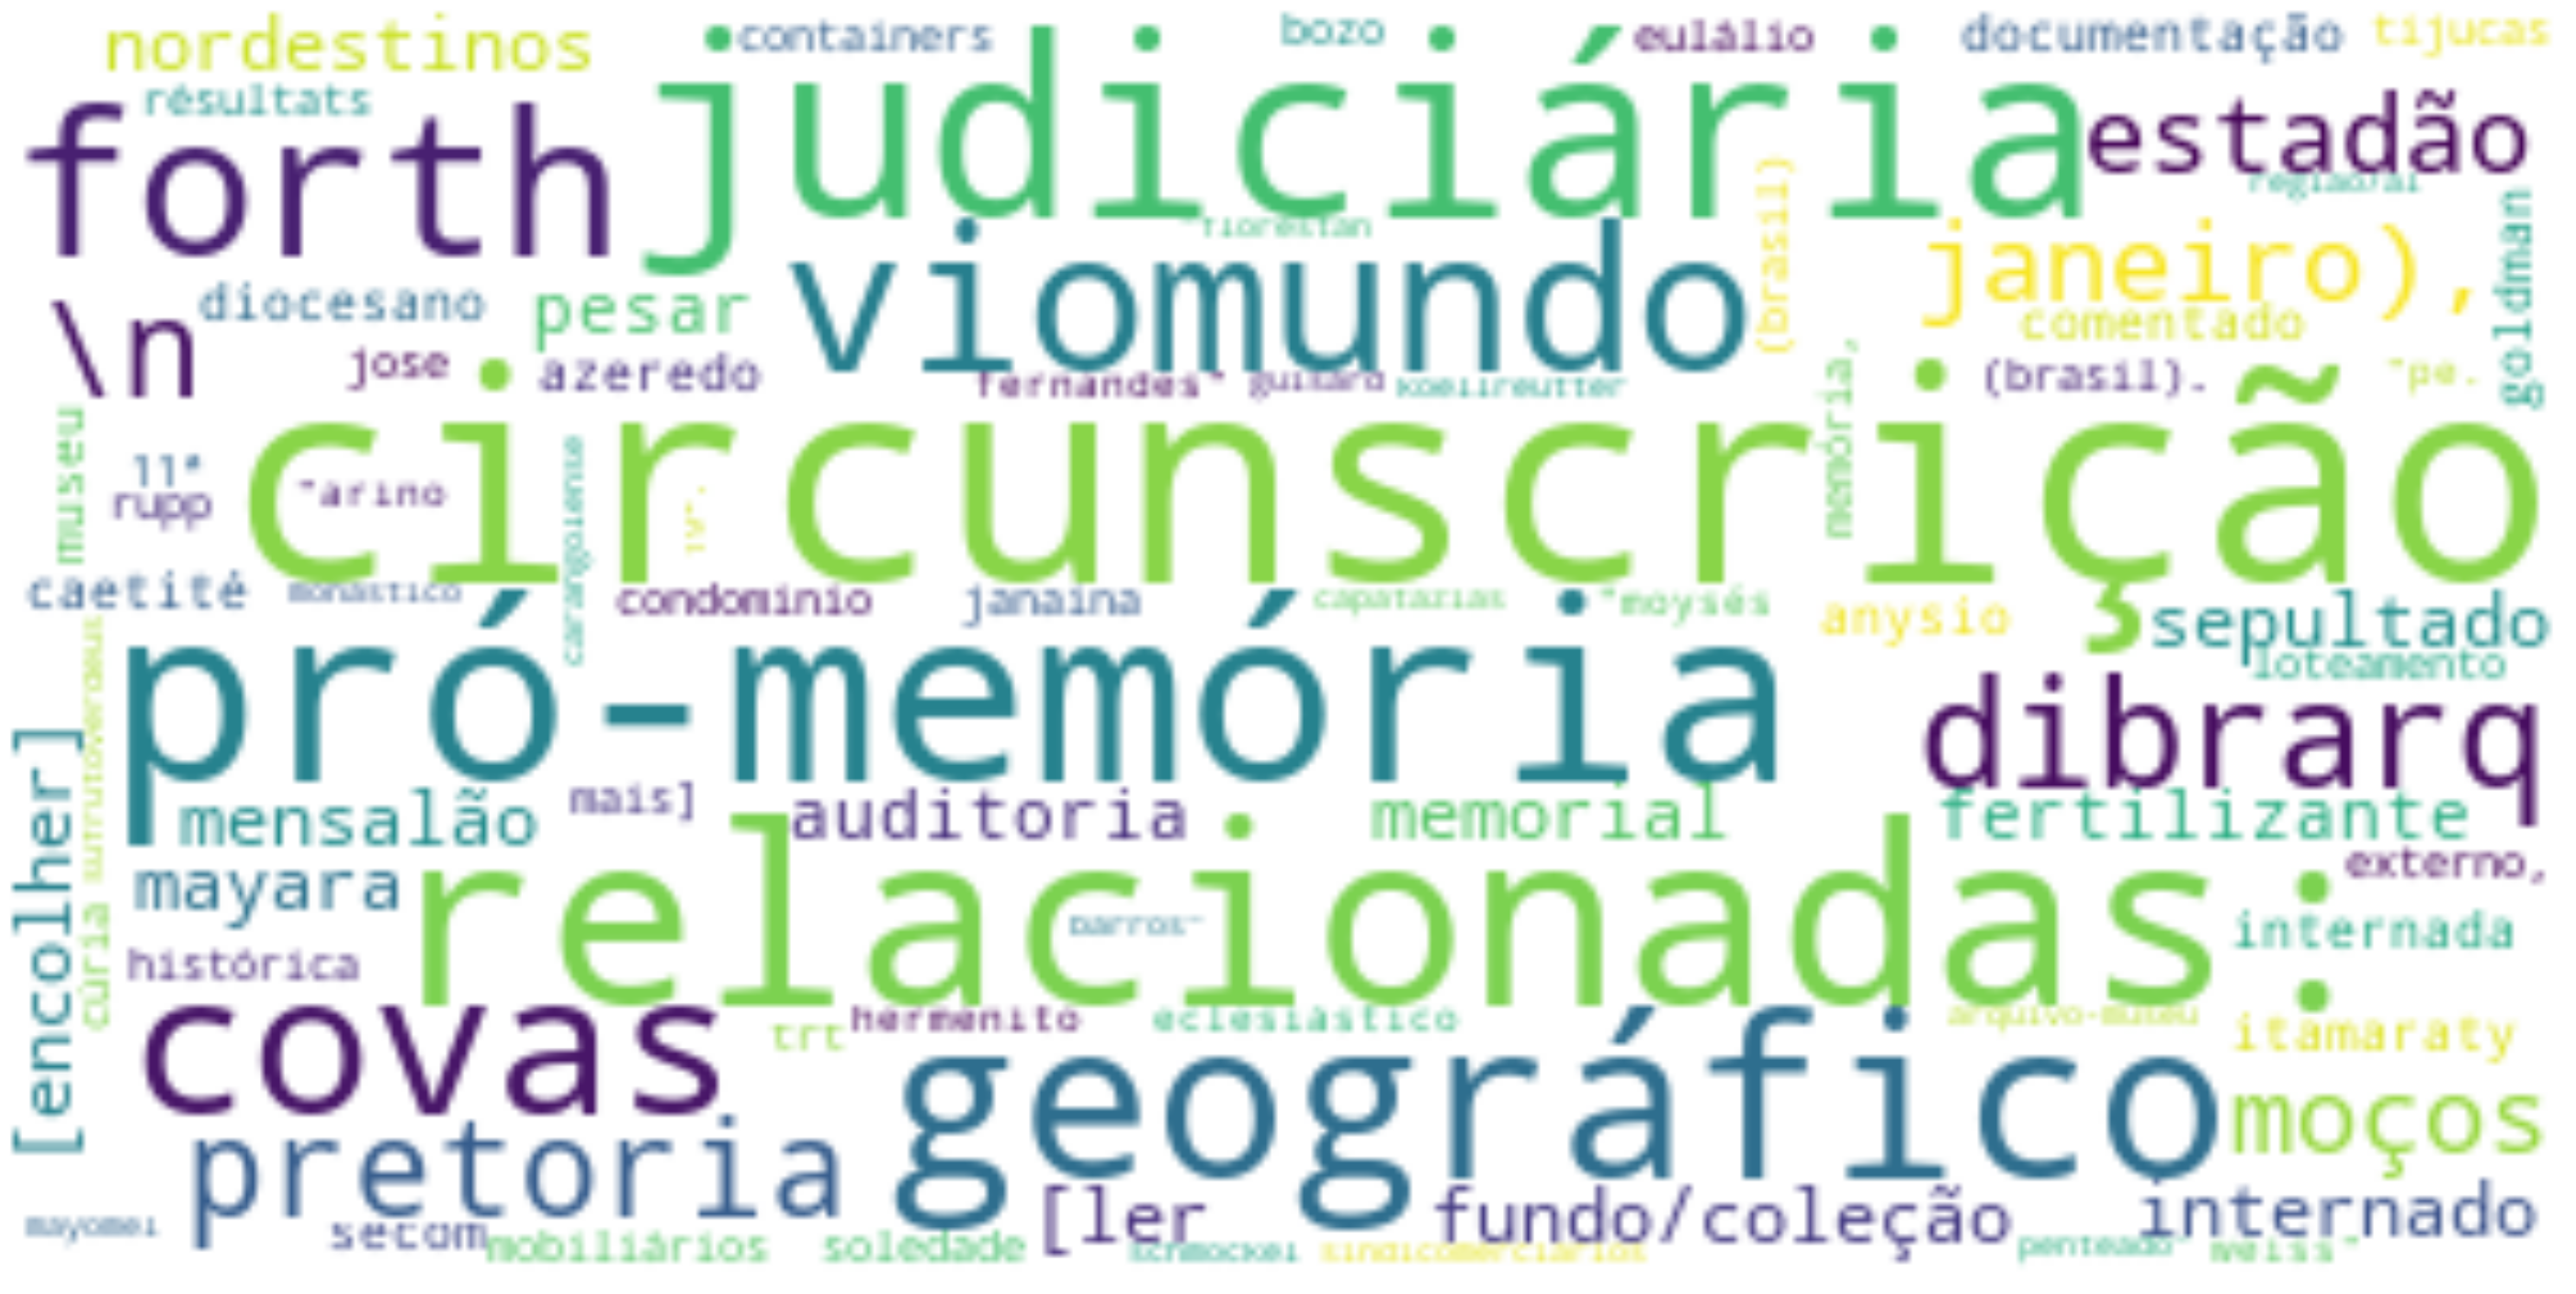

Covas


In [89]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra2))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Covas")

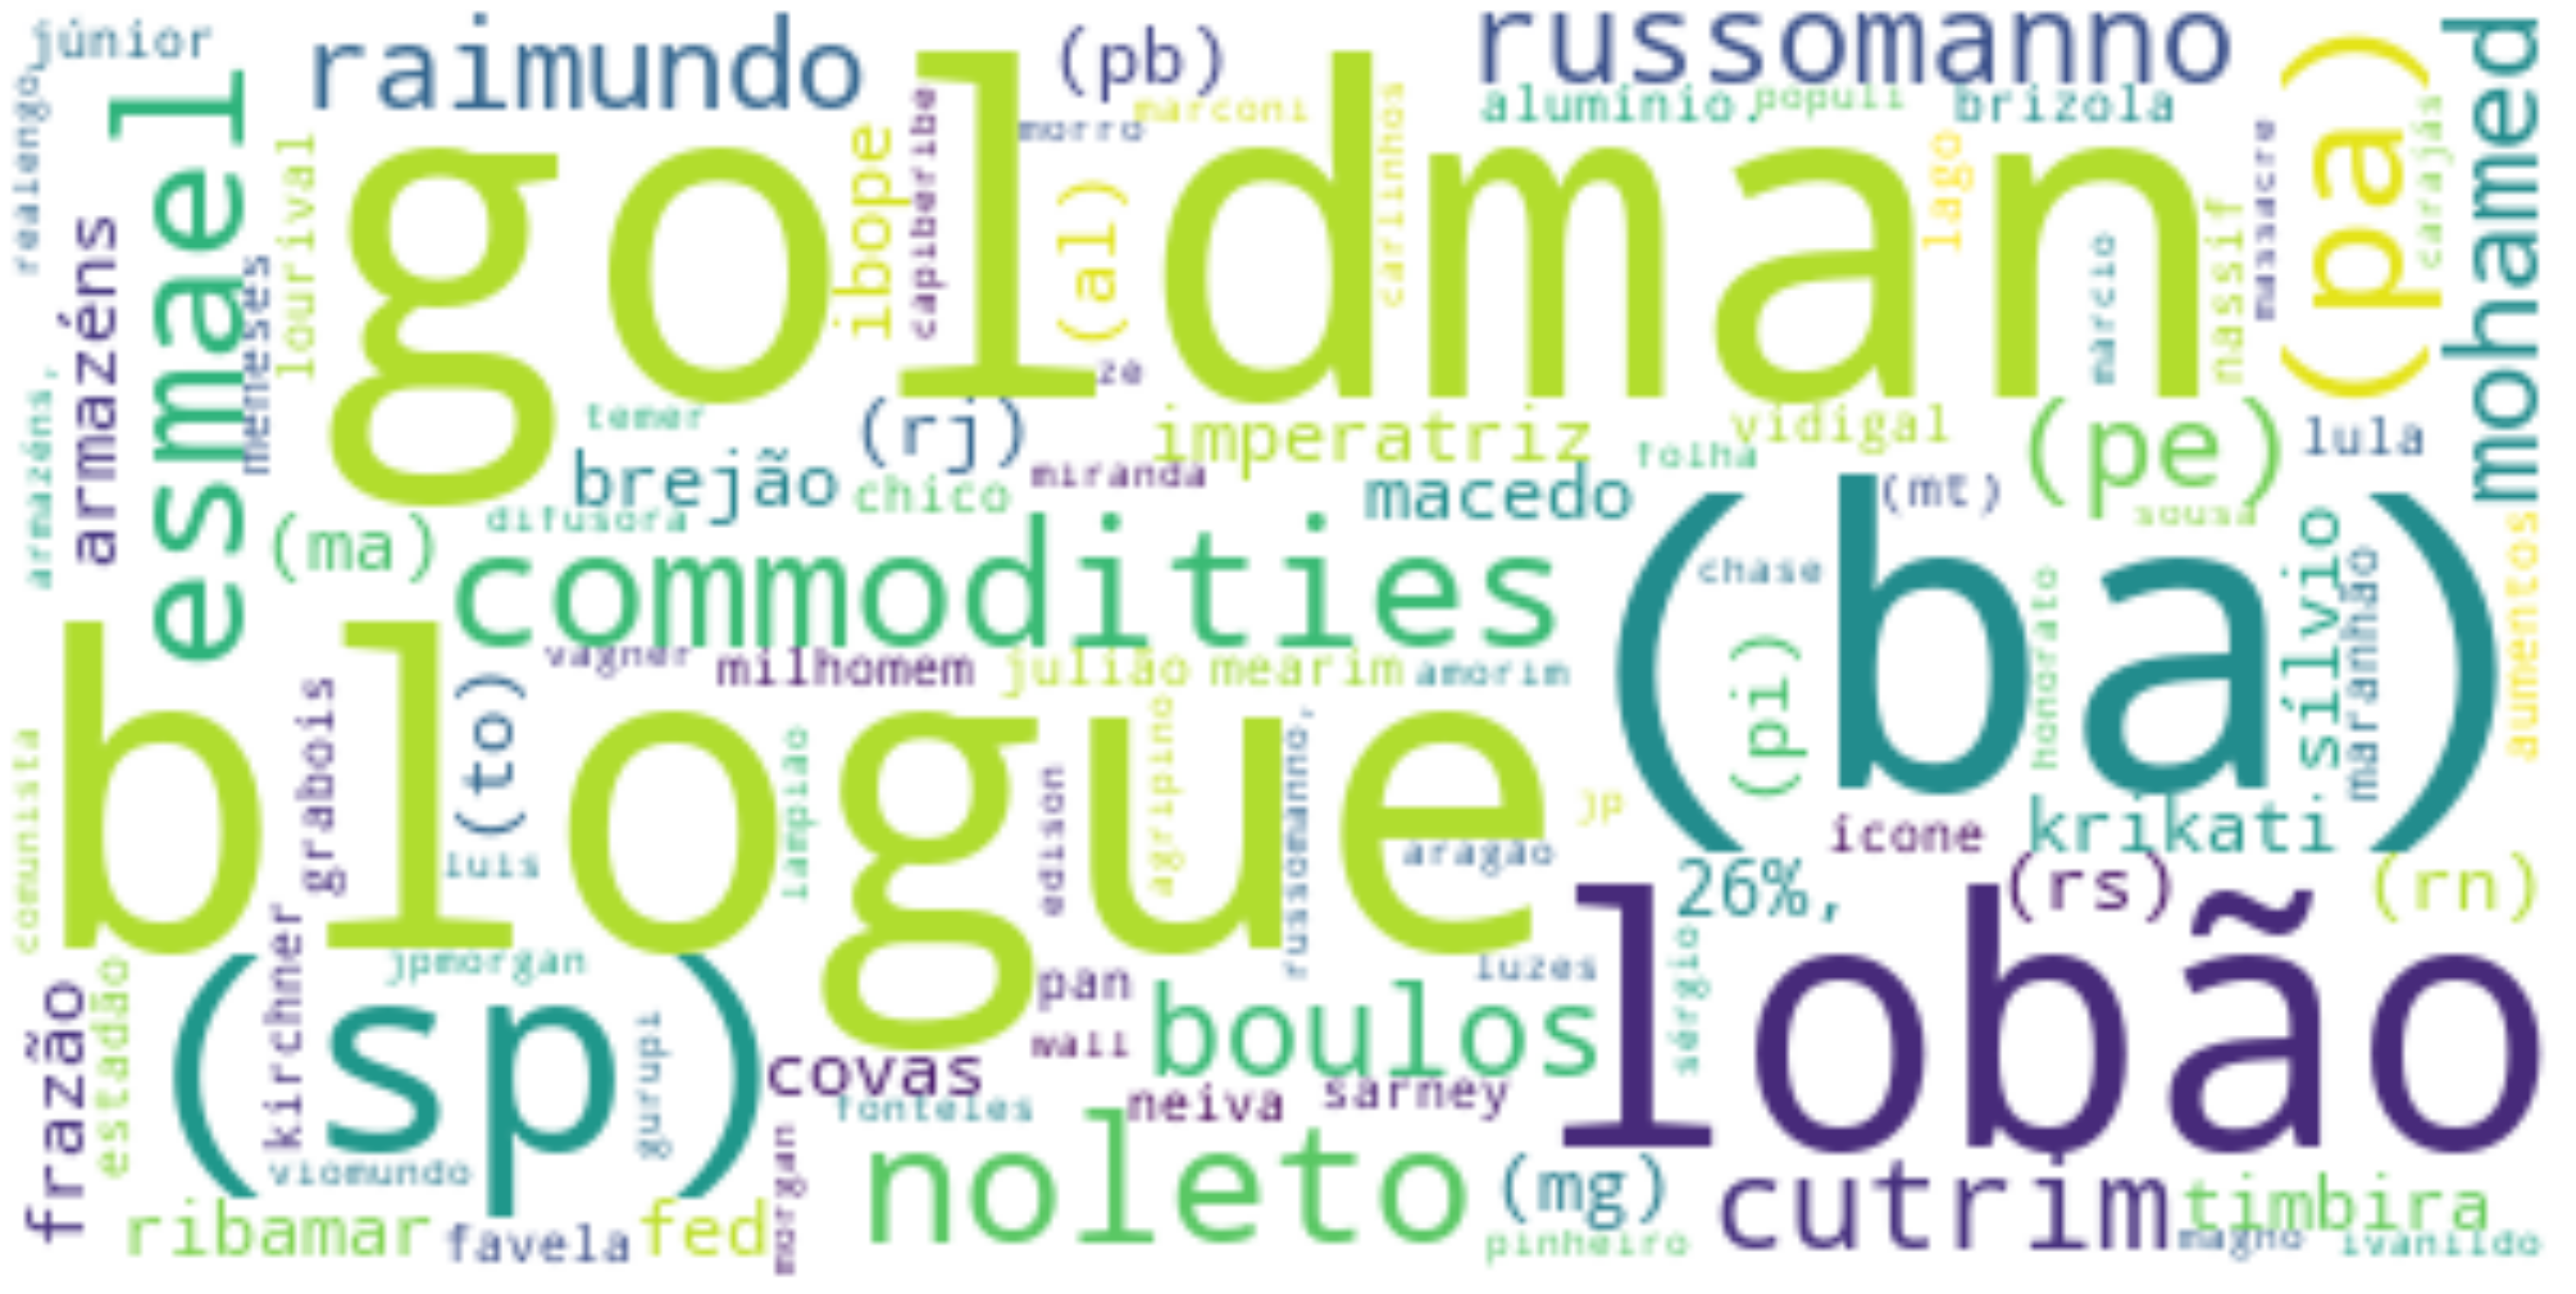

Inter


In [90]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Inter")